# Apply Topic Modelling Analysis on COVID-19 Documents with NMF

This jupyter notebook demonstrates document clustering with NMF topic modelling and generating tags from the clustered documents.

**About NMF**

- NMF : Non-Negative Matrix Factorization (NMF) is an unsupervised technique. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative. Using the original matrix (X), NMF will give you two matrices (W and H). W is the topics it found and H is the coefficients (weights) for those topics. In other words, X is articles by words (original), H is articles by topics and W is topics by words.


In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import pickle
import seaborn as sns
import json
import nltk
import ast
import datetime as dt
import operator
import re
import pathlib
import timeit
from wordcloud import WordCloud
from collections import Counter
from sklearn import decomposition
from sklearn.decomposition import NMF
from itertools import combinations
import warnings
import sys

warnings.filterwarnings('ignore')

In [2]:
PATH = '../coronavirus_twenty_years_of_research/technical_validation/'

## Load data

In [3]:
df = pd.read_csv(PATH + "merged_covid_articles.tsv", sep='\t', encoding='utf-8')
V = pickle.load( open(PATH + "_V_tfidf.pkl", "rb") )
D = pickle.load( open(PATH + "_D_tfidf.pkl", "rb") )

## Apply topic modelling

In [5]:
k = int(8)
NMF_model = NMF(n_components=k, init='nndsvd', random_state=1).fit(D)
H = NMF_model.transform(D) # articles by topic
W = NMF_model.components_  # topics by words.

In [6]:
# identify first and second topic for each article

top2_clusters_df = pd.DataFrame()
top2_clusters_df['_id'] = df['_id']

top_1_cluster_list=[]
top_2_cluster_list=[]
top_1_cluster_weight_list=[]
top_2_cluster_weight_list=[]

for a in H:
    top_2_idx = np.argsort(a)[-2:]
    top_2_values = [a[i] for i in top_2_idx]
    top_1_cluster_list.append(str(top_2_idx[1]))
    top_2_cluster_list.append(str(top_2_idx[0]))
    top_1_cluster_weight_list.append(round(top_2_values[1], 5))
    top_2_cluster_weight_list.append(round(top_2_values[0], 5))
    
top2_clusters_df['top1_cluster'] = top_1_cluster_list
top2_clusters_df['top2_cluster'] = top_2_cluster_list
top2_clusters_df['top1_cluster_weight'] = top_1_cluster_weight_list
top2_clusters_df['top2_cluster_weight'] = top_2_cluster_weight_list

# Explore topic modelling results

## Print clusters keywords 

In [10]:
def get_top_keyword_weights(model, optimal_topic_size, n_top_words, V):
    
    feat_names = V.get_feature_names_out()
    
    word_dict = {};
    for i in range(optimal_topic_size):
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Cluster # ' + '{:02d}'.format(i)] = words;
    
    return pd.DataFrame(word_dict);

In [11]:
def get_top_keyword_weights(model, optimal_topic_size, n_top_words, V):
    feature_names = V.get_feature_names_out()
    keywords_df = pd.DataFrame()
    k = 0
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        keywords_df["Cluster #{} keywords".format(k)] = top_features
        keywords_df["Cluster #{} keywords weights".format(k)] = weights
        k +=1
    return keywords_df

In [38]:
number_of_top_keywords = 30
keywords_df = get_top_keyword_weights(NMF_model, k, number_of_top_keywords, V)
keywords_df.to_csv(PATH+"figure6_{}Keywords_in_{}_clusters_with_weights.csv".format(number_of_top_keywords, k), sep=',', encoding='utf-8', index=False)

In [14]:
def print_top_keyword_weights(model, optimal_topic_size, n_top_words, V):
    feature_names = V.get_feature_names_out()
    fig, axes = plt.subplots(2, 4, figsize=(30, 16), sharex=True)
    axes = axes.flatten()
   
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
    
        for p in ax.patches:
            if topic_idx == 0:
                ax.annotate(str(round(p.get_width(),2)), (6.5, p.get_y() + p.get_height()),size=16)
            else:
                ax.annotate(str(round(p.get_width(),2)), (5.5, p.get_y() + p.get_height()),size=16)
            #ax.annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height()/8),fontsize=12)
            #print(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height()))
    
        ax.set_title(f"Cluster# {topic_idx}", fontdict={"fontsize": 20})
        
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        #fig.suptitle(title, fontsize=40)
    
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.savefig('../img/Figure6-Top-10-keywords-for-clusters.jpeg', dpi=2000, bbox_inches='tight') 
    plt.show()

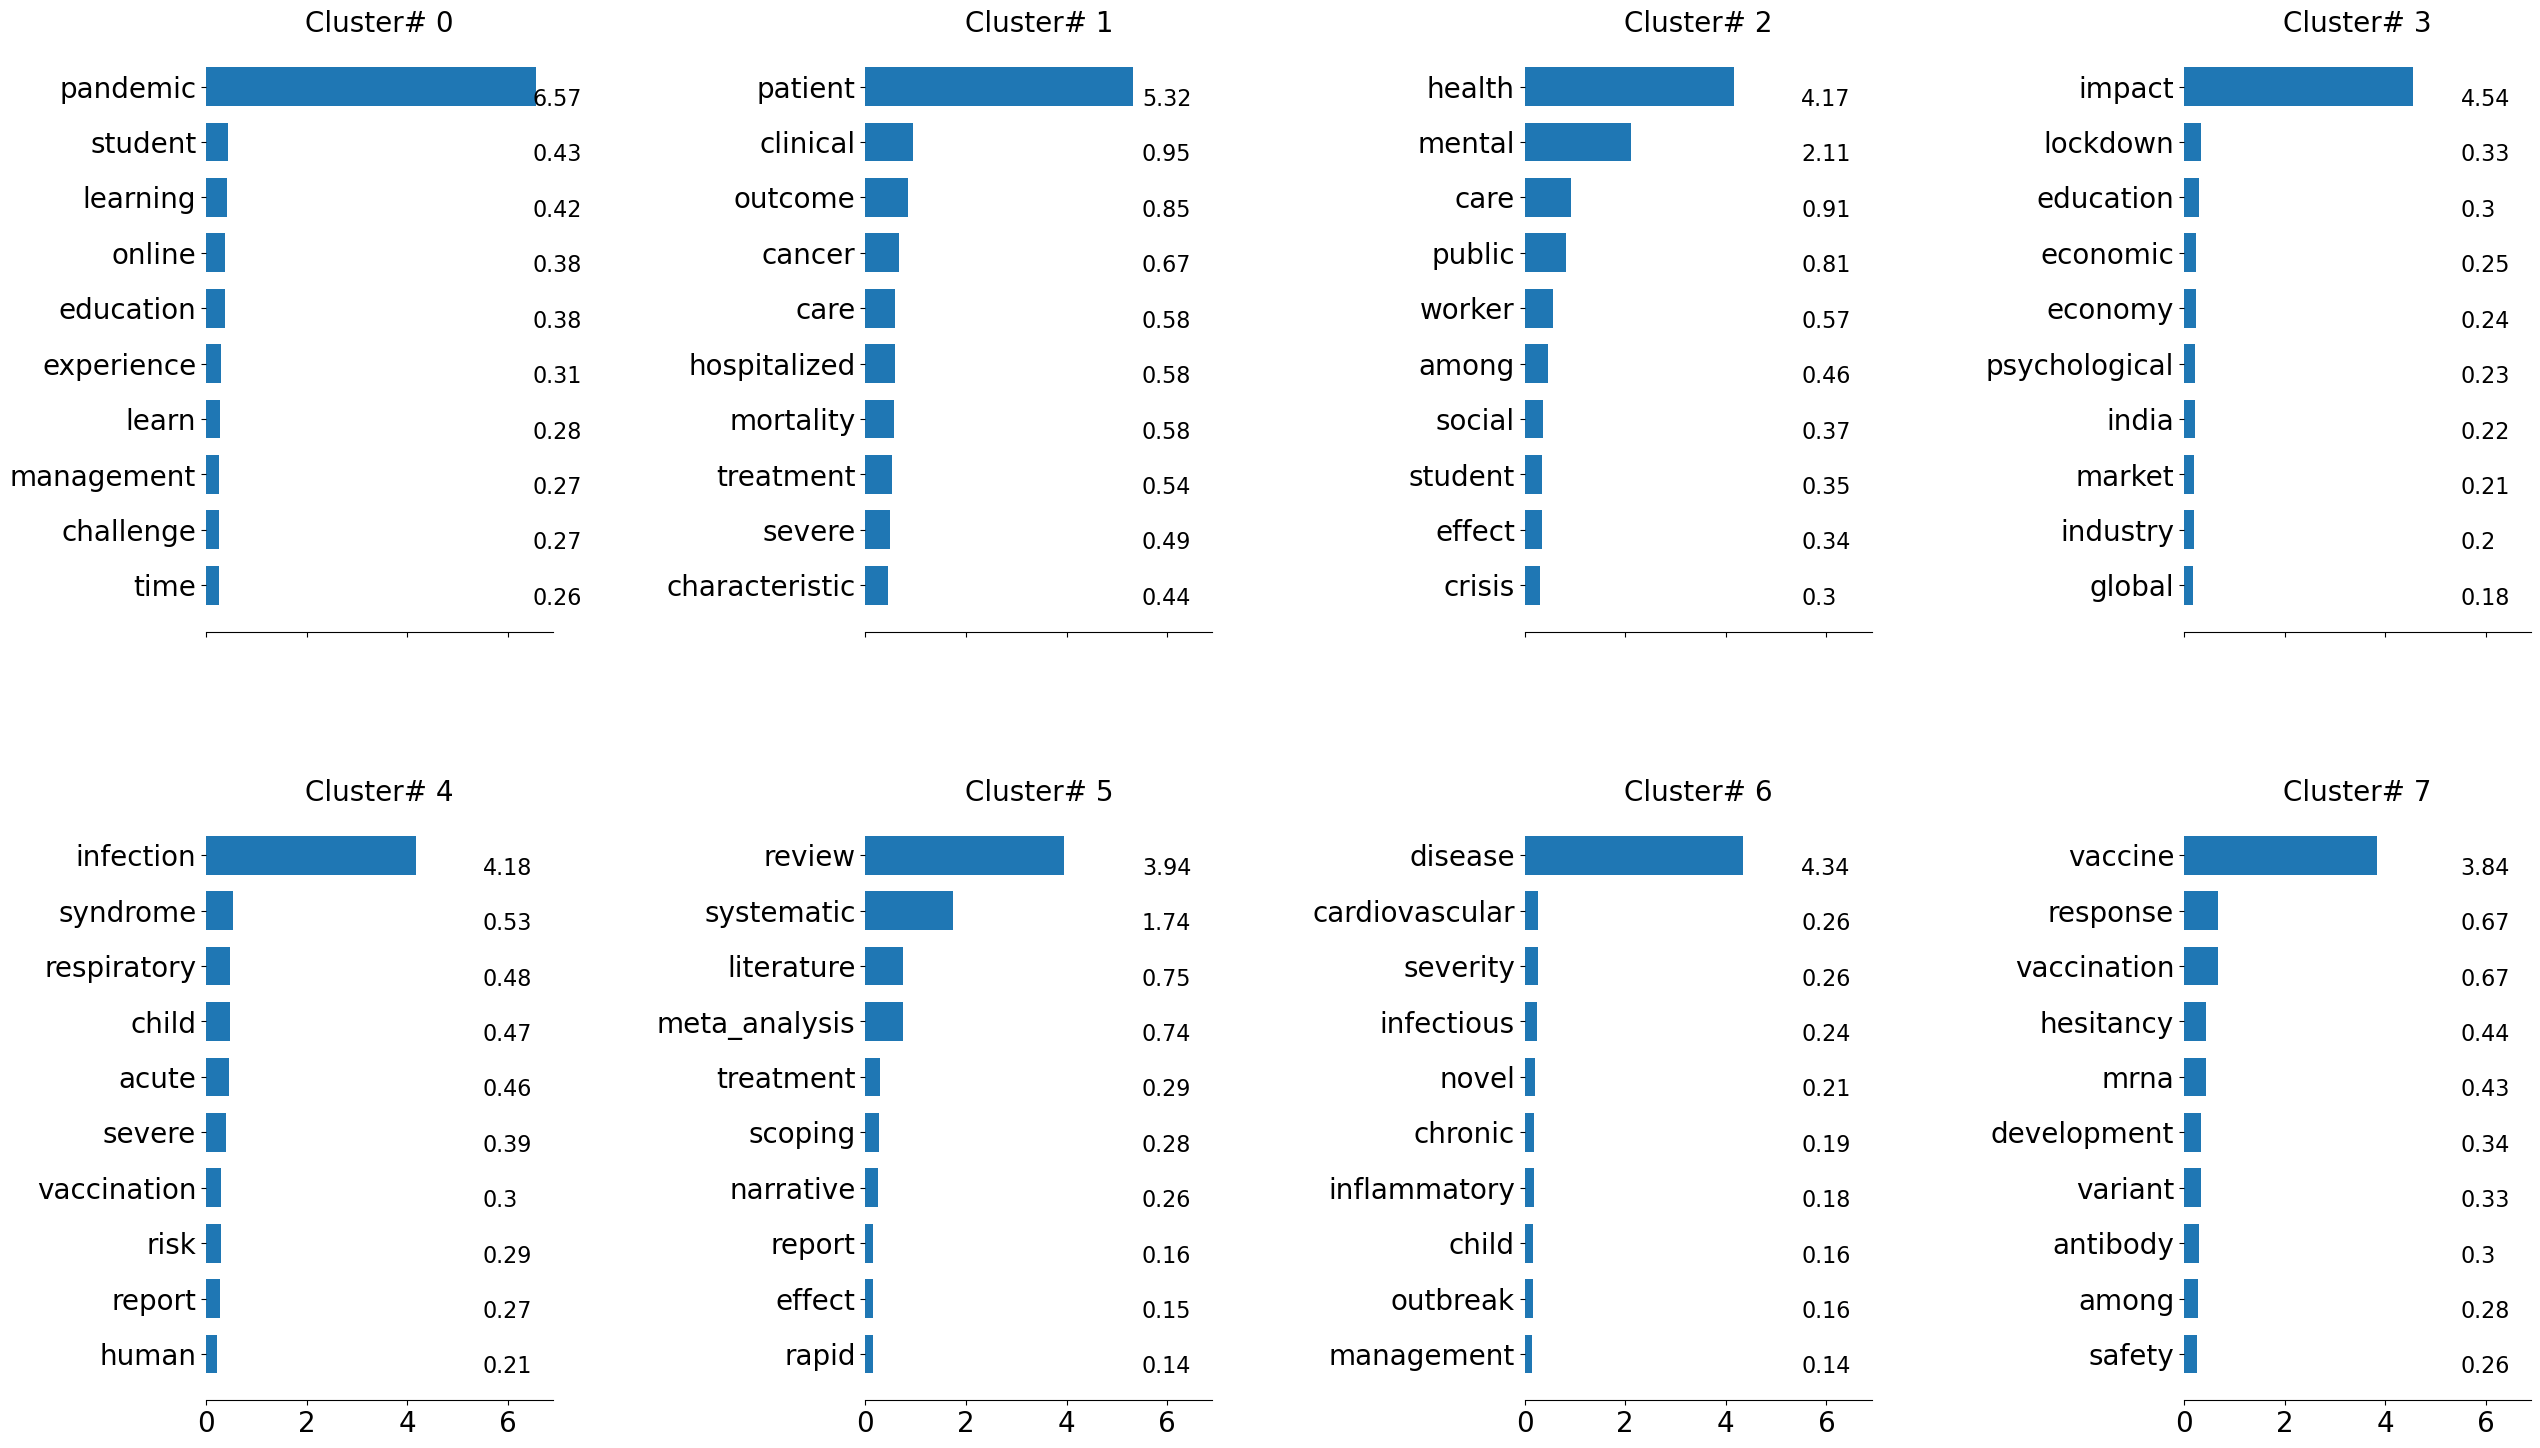

In [15]:
print_top_keyword_weights(NMF_model, k, 10, V)

## Print number of articles in the clusters

In [16]:
def show_distribution(unique, top1_num_of_articles):
    plt.figure(figsize=(12, 6))

    plt.bar(unique, top1_num_of_articles)
    plt.yticks(fontsize=14)
    plt.xticks(unique, unique)
    plt.ylabel('Number of research articles', fontweight='bold', fontsize=14)
    plt.xlabel('Clusters', fontweight='bold', fontsize=14)
    for index, value in enumerate(top1_num_of_articles):
        plt.text(index-0.3, top1_num_of_articles[index]+1000, f"{top1_num_of_articles[index]:,}", fontsize=12)
    plt.legend()
    #plt.grid(True, axis='y')
    plt.savefig('../img/Figure13-Distribution-of-articles-across-clusters.jpeg', dpi=2000, bbox_inches='tight')  
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


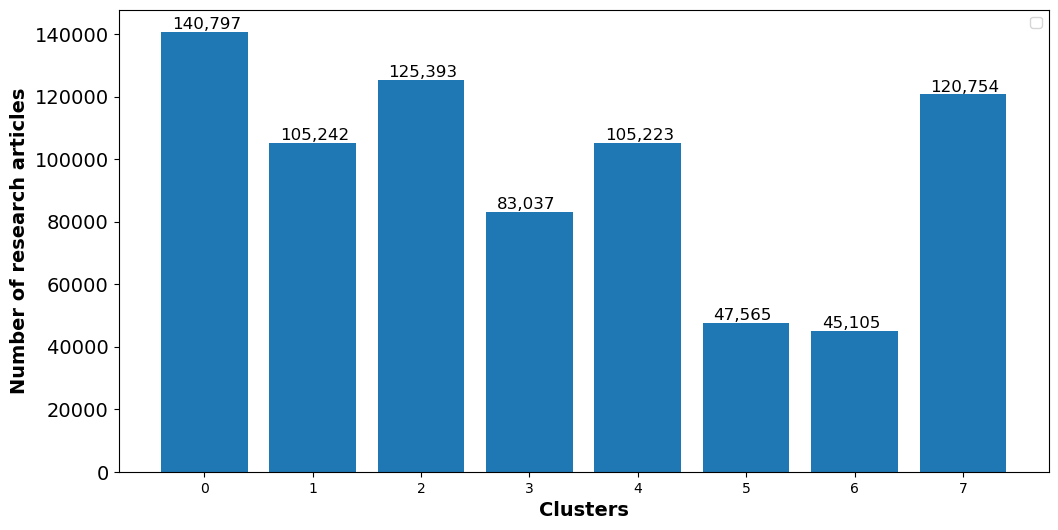

In [41]:
# show number of articles per cluster
articles_num = []
for cluster in range(k):
    articles_num.append(len(top2_clusters_df.loc[top2_clusters_df['top1_cluster'] == str(cluster)]))
    
unique = range(k)
show_distribution(unique, articles_num)

article_ditribution_df = pd.DataFrame()
article_ditribution_df['Research cluster'] = unique 
article_ditribution_df['Number of articles'] = articles_num 
article_ditribution_df.to_csv(PATH+"figure13_number_of_articles_by_cluster.csv", sep=',', encoding='utf-8', index=False)

## Article co-occurrence 

In [18]:
# Identify Sum of x and number of x

c_pair_x_num = {} # coumt number of x
c_pair_x_sum = {} # sum of x
for index, row in top2_clusters_df.iterrows():
    c_pair = (row['top1_cluster'], row['top2_cluster'])
    if c_pair not in c_pair_x_num.keys():
        c_pair_x_num[c_pair] = 1
    else:
        c_pair_x_num[c_pair] += 1

In [19]:

co_oc_df = pd.DataFrame(columns=['Cluster1', 'Cluster2', '# articles'])
for i in range(k):
    for j in range(k):
        if i == j:continue
        co_oc_df = co_oc_df._append({
            "Cluster1":str(i),
            "Cluster2":str(j),
            "# articles":str(c_pair_x_num[(str(i), str(j))] + c_pair_x_num[(str(j), str(i))])}, ignore_index=True)


In [20]:
# convert DF to matrix format

matrix_df = pd.DataFrame()
for c1 in range(k):
    placeholders = []
    for c2 in range(k):
        placeholders.append(0)
    matrix_df[c1] = placeholders
    
for index, row in co_oc_df.iterrows():
    cluster1 = int(str(row['Cluster1']).replace('.0', ''))
    cluster2 = int(str(row['Cluster2']).replace('.0', ''))
    
    cooccurrence = row['# articles']
    num_articles_in_first_collection = len(top2_clusters_df.loc[top2_clusters_df['top1_cluster'] == str(cluster1)])
    num_articles_in_second_collection = len(top2_clusters_df.loc[top2_clusters_df['top1_cluster'] == str(cluster2)])
    co_rate = round(int(cooccurrence)/(num_articles_in_first_collection + num_articles_in_second_collection), 3)
    matrix_df[cluster2].iloc[cluster1] = co_rate

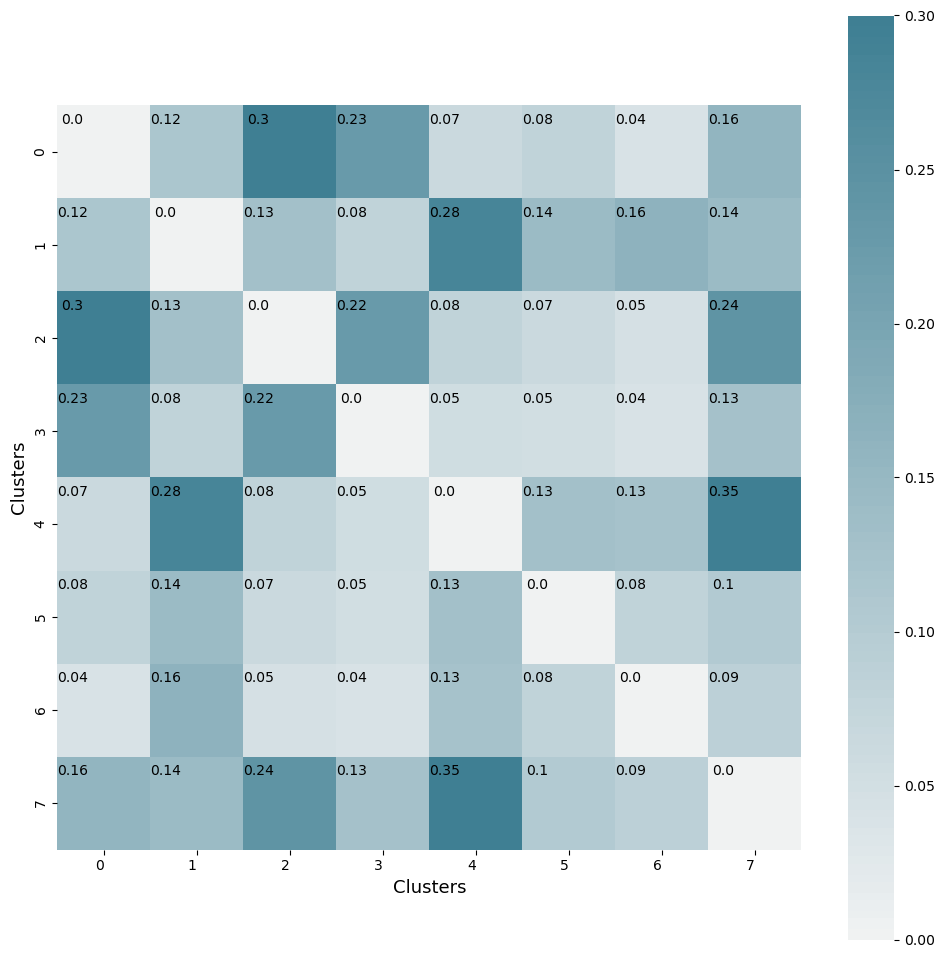

In [21]:

fig, ax = plt.subplots(figsize=(12,12))         
ax = sns.heatmap(
    matrix_df, 
    vmin=0, vmax=0.3, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    horizontalalignment='right'
);
j = k
for c in matrix_df.columns:
    i = 0
    for index, row in matrix_df.iterrows():
        value = row[c]
        ax.text(i/k+0.02, j/k-0.02, round(value, 2), horizontalalignment='center',
             verticalalignment='center', transform=ax.transAxes)
        i += 1
    j -= 1
plt.xlabel('Clusters', fontsize = 13) 
plt.ylabel('Clusters', fontsize = 13) 

plt.savefig('../img/Figure10-Articles-co-occurrence-rate-over-the-clusters.jpeg', dpi=400, bbox_inches='tight')

In [42]:
matrix_df.to_csv(PATH + "figure10_cooccurrence_matrix.csv", index=False)

## Trend of articles per cluster

In [7]:
# merge the result to preprocessed data
df = pd.merge(top2_clusters_df[['_id', 'top1_cluster']], df, on='_id', how='left')

In [8]:
def cleaning_text(date):
    row_value = ast.literal_eval(date)
    year = row_value['date-parts'][0][0]
    month = row_value['date-parts'][0][1]
    day = 1
    return "{}/{}/{}".format(month, day, year)

In [9]:
text_cleaning = lambda x: cleaning_text(x)

df['date'] = df['created'].apply(text_cleaning)
df['date'] = pd.to_datetime(df['date']).dt.to_period('M')
sorted_df = df.sort_values(by=['date'], inplace=False) # sort by date

In [10]:
# Only use top1 cluster

sub_df = sorted_df[['_id', 'top1_cluster', 'date']]
sub_df['top1_cluster'] = sub_df['top1_cluster'].apply(lambda x:'Cluster#' + '{:02d}'.format(int(x)))

In [11]:
groupby_sub_df = sub_df.groupby(['date', 'top1_cluster'])["_id"].count().reset_index(name="count")

In [12]:
# convert pivot table, thus each topic become column where value indicate number of document
table = pd.pivot_table(groupby_sub_df, values='count', index=['date'],
                    columns=['top1_cluster'], aggfunc=np.sum, fill_value=0)

table = table.reindex(sorted(table.columns), axis=1)

In [13]:
# convert table where values are cumulative
cum_table = table.cumsum(axis=0)

rank_cum_table = pd.DataFrame(columns=list(cum_table.columns))
i = 0
for index, row in cum_table.iterrows():
    l = cum_table.iloc[i]
    result = [sorted(l, reverse=True).index(x)+1 for x in l]
    rank_cum_table.loc[i] = result
    i += 1
    
rank_cum_table.index= cum_table.index

In [21]:
table.to_csv("data_for_cluster_racing_video.csv")
table

top1_cluster,Cluster#00,Cluster#01,Cluster#02,Cluster#03,Cluster#04,Cluster#05,Cluster#06,Cluster#07
date,,,,,,,,
2002-07,0,2,3,1,71,2,18,40
2002-08,0,0,0,0,6,0,0,2
2002-09,0,0,0,0,25,0,4,15
2002-10,1,1,1,0,40,1,8,13
2002-11,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...
2023-08,2513,1607,2261,1500,2118,946,701,2128
2023-09,2367,1446,2166,1514,1489,874,570,2063
2023-10,2406,1772,2293,1560,1678,793,606,1946


In [29]:
def bumpchart(df, selected_collections, show_rank_axis= True, rank_axis_distance= 1.1, 
              ax= None, scatter= False, holes= False,
              line_args= {}, scatter_args= {}, hole_args= {}):
    
    fig = plt.figure(figsize=(9,6))
    if ax is None:
        left_yaxis= plt.gca()
    else:
        left_yaxis = ax

    # Creating the right axis.
    right_yaxis = left_yaxis.twinx()
    
    axes = [left_yaxis, right_yaxis]
    
    # Creating the far right axis if show_rank_axis is True
    if show_rank_axis:
        far_right_yaxis = left_yaxis.twinx()
        axes.append(far_right_yaxis)
    flag = 0
    for col in df.columns:
        y = df[col]
        x = df.index.values
        # Plotting blank points on the right axis/axes 
        # so that they line up with the left axis.
        for axis in axes[1:]:
            axis.plot(x, y, alpha= 0)
            
        if col not in selected_collections:
            left_yaxis.plot(x, y, **line_args, solid_capstyle='round', color='grey', alpha=0.1)
            
            # Adding scatter plots
            if scatter:
                left_yaxis.scatter(x, y, **scatter_args, color='green', alpha=0.1)
                
                #Adding see-through holes
                if holes:
                    bg_color = left_yaxis.get_facecolor()
                    left_yaxis.scatter(x, y, color= bg_color, **hole_args)
        else: # highlight selected values
            if flag != 1: c = 'red'
            else: c='blue'
            left_yaxis.plot(x, y, **line_args, solid_capstyle='round', color=c, label=col)
            left_yaxis.legend(loc='upper right', fontsize=12)
            left_yaxis.set_xlabel("Date")
            left_yaxis.set_ylabel("Rank")
            # Adding scatter plots
            if scatter:
                left_yaxis.scatter(x, y, **scatter_args, color=c)

                #Adding see-through holes
                if holes:
                    bg_color = left_yaxis.get_facecolor()
                    left_yaxis.scatter(x, y, color= bg_color, **hole_args)
            flag = 1
    # Number of lines
    lines = len(df.columns)
    y_ticks = [*range(0, lines)]
    
    x_ticks = []
    for j in range(1, len(df.index)+1, 12):
        x_ticks.append(rank_cum_table.index[j])
    
    # Configuring the axes so that they line up well.
    for axis in axes:
        axis.invert_yaxis()
        axis.set_yticks(y_ticks)
        axis.set_ylim((lines + 0.5, 0.5))

    start_date = df.index.min()
    end_date = df.index.max()
    
    left_yaxis.set_xlim(start_date, end_date)
    
    # Sorting the labels to match the ranks.
    left_labels = df.iloc[0].sort_values().index
    right_labels = df.iloc[-1].sort_values().index
    
    axis.xaxis.set_major_locator(plt.MaxNLocator(12))
    
    return axes

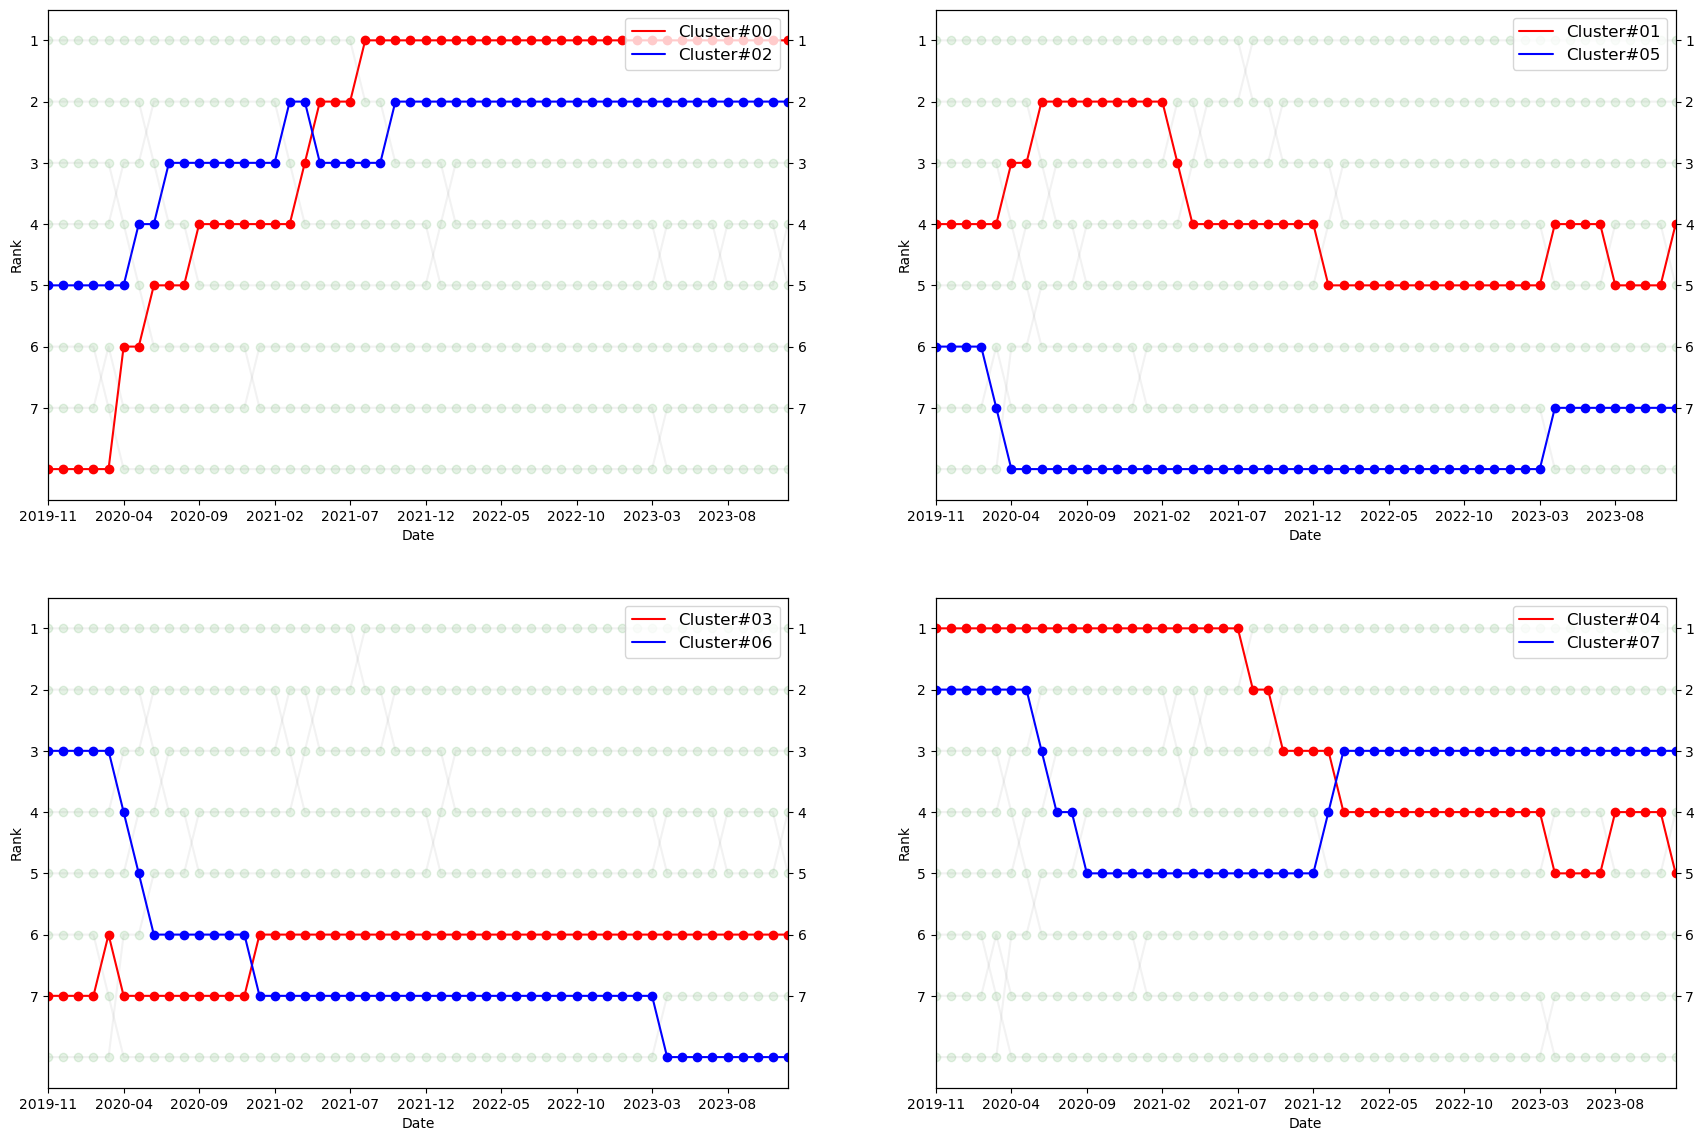

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

In [30]:
fig, axs = plt.subplots(2,2, figsize=(21,14))

last_month = 50
rank_cum_table.index = rank_cum_table.index.astype(str)

bumpchart(rank_cum_table.tail(last_month), ['Cluster#00', 'Cluster#02'], show_rank_axis= False, scatter=True, ax=axs[0][0])
bumpchart(rank_cum_table.tail(last_month), ['Cluster#01', 'Cluster#05'], show_rank_axis= False, scatter=True, ax=axs[0][1])
bumpchart(rank_cum_table.tail(last_month), ['Cluster#03', 'Cluster#06'], show_rank_axis= False, scatter=True, ax=axs[1][0])
bumpchart(rank_cum_table.tail(last_month), ['Cluster#04', 'Cluster#07'], show_rank_axis= False, scatter=True, ax=axs[1][1])

fig.savefig("../img/Figure14-Research-topic-trends-vary-over-time.jpeg", dpi=200)
fig.show()

In [43]:
rank_cum_table.to_csv(PATH + "figure14_article_trend.csv", index=False)

## Wordcloud

We create wordcloud for each cluster based on word frequency of top 1 cluster articles (Exclude articles matched with top2 clusters). 

In [31]:
import random 

font_path = "/Library/Fonts/Arial.ttf"

def getRandomCol():
    r = random.randrange(30, 180)
    g = random.randrange(30, 180)
    b = random.randrange(30, 180)
    return (r, g, b)

def show_wordcloud(df):
    #topics = list(set(df['research_topic']))
    i = 0
    fig = plt.figure(figsize=(18,5))
    for t in range(k):
        ax = fig.add_subplot(2,4,i+1)
        topic_df = df.loc[df['top1_cluster'] == str(t)]
        text = ''
        for index, row in topic_df.iterrows():
            text += row['text']
        wordcloud = WordCloud(background_color="white", collocations=False).generate(str(text))
        plt.title("Cluster {}".format(t))
        colour = getRandomCol()
        ax.imshow(wordcloud.recolor(color_func=lambda *args, **kwargs: colour))
        ax.axis('off')
        i += 1
    plt.tight_layout()
    plt.savefig('../img/Figure7-Word-cloud-for-each-topic-cluster.jpeg', dpi=300, bbox_inches='tight')
    plt.show()

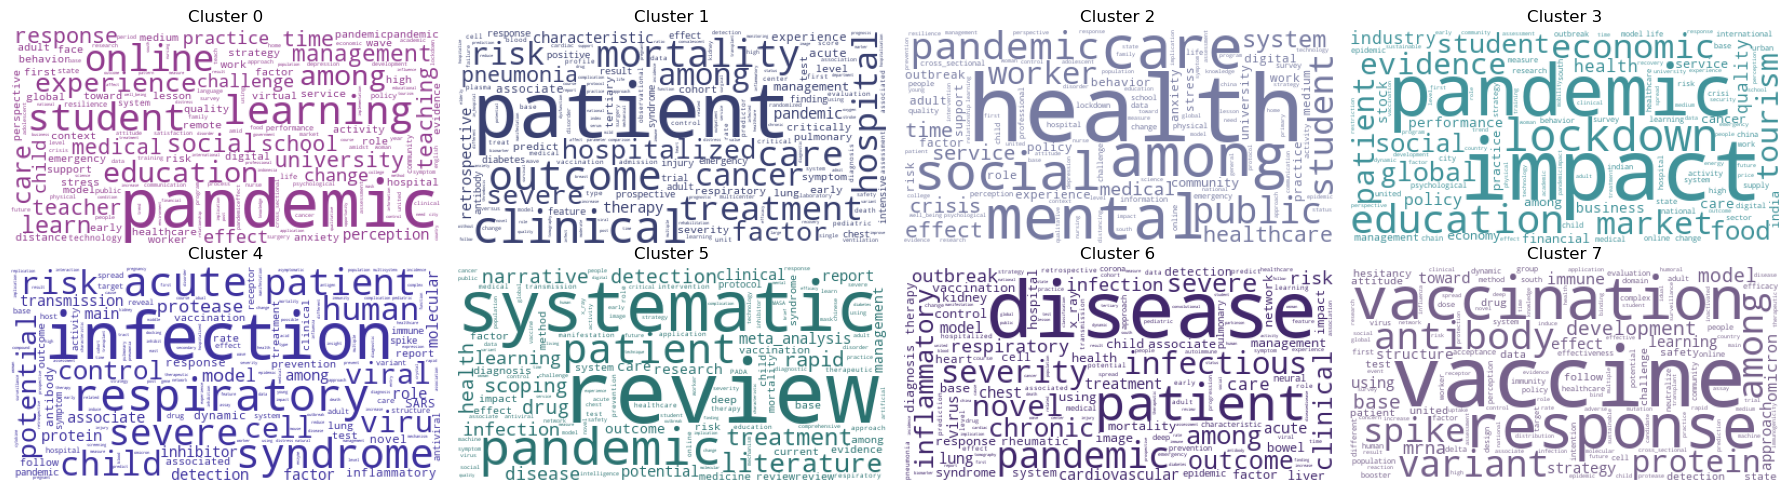

In [32]:
show_wordcloud(df)

In [44]:
def word_counter(topic_text_df, t):
    word_freq_dict = {}
    words_array = []
    counts_array = []

    for row in topic_text_df.text:
        words = row.split()
        for word in words:
            if word in word_freq_dict:
                word_freq_dict[word] += 1
            else:
                word_freq_dict[word] = 1

    sorted_word_freq = dict(sorted(word_freq_dict.items(), key=lambda item: item[1], reverse=True))
    top_words = list(sorted_word_freq.items())[:100]
    for word, count in top_words:
        words_array.append(word)
        counts_array.append(count)
    
    return [words_array, counts_array]

In [45]:
word_freq_df = pd.DataFrame()

for t in range(k):
    topic_df = df.loc[df['top1_cluster'] == str(t)]
    word_counts = word_counter(topic_df, t)
    word_freq_df['cluster_{}_words'.format(t)] = word_counts[0]
    word_freq_df['cluster_{}_words_frequency'.format(t)] = word_counts[1]
word_freq_df.to_csv(PATH + "figure7_word_frequency_for_wordcloud(top100).csv", index=False)

## MetaData

In [24]:
def count_publisher(df):
    missing_article = df['publisher'].isnull().sum()
    percent = round(missing_article/len(df)*100, 1)
    print("Missing publisher: {} ({}%)".format(missing_article, percent))
    publisher_df = df.groupby('publisher')['_id'].nunique().sort_values(ascending=False).to_frame().reset_index()
    publisher_df.columns = ['publisher','Number of publications']
    return publisher_df

In [25]:
def count_subjects(df):
    missing_article = df['subject'].isnull().sum()
    print("Missing subject: {} ({}%)".format(missing_article, round(missing_article/len(df)*100, 1)))
    subjects_dict = {}
    for index, row in df.iterrows():
        if len(str(row['subject'])) > 3:
            subjects = eval(row['subject'])
            for s in subjects:
                if s in subjects_dict.keys():
                    subjects_dict[s] += 1
                else:
                    subjects_dict[s] = 1

    sorted_sub_dict = dict( sorted(subjects_dict.items(), key=operator.itemgetter(1),reverse=True))
    subject_df = pd.DataFrame()
    subject_df['Subjects'] = sorted_sub_dict.keys()
    subject_df['Number of publications'] = sorted_sub_dict.values()
    return subject_df

In [26]:
def count_container(df):
    df['container-title'] = df['container-title'].astype(str)
    missing_article = len(df.loc[df['container-title'] == 'nan'])
    print("Missing container: {} ({}%)".format(missing_article, round(missing_article/len(df)*100, 1)))
    df = df.loc[df['container-title'] != 'nan']
    container_df = df.groupby('container-title')['_id'].nunique().sort_values(ascending=False).to_frame().reset_index()
    container_df.columns = ['container_title','Number of publications']
    container_df['container_title'] = container_df['container_title'].apply(lambda x: x.replace("['", ''))
    container_df['container_title'] = container_df['container_title'].apply(lambda x: x.replace("']", ''))
    return container_df

In [27]:
def count_funder(df):
    df['funder'] = df['funder'].astype(str)
    missing_article = len(df.loc[df['funder'] == 'nan'])
    print("Missing funder: {} ({}%)".format(missing_article, round(missing_article/len(df)*100, 1)))
    df = df.loc[df['funder'] != 'nan']
    funder_dict = {}
    for index, row in df.iterrows():
        if len(str(row['funder'])) > 3:
            funders = eval(row['funder'])
            for f in funders:
                try:
                    funder = f['name']
                    if funder in funder_dict.keys():
                        funder_dict[funder] += 1
                    else:
                        funder_dict[funder] = 1
                except:
                    continue

    sorted_funder_dict = dict( sorted(funder_dict.items(), key=operator.itemgetter(1),reverse=True))
    funder_df = pd.DataFrame()
    funder_df['Funders'] = sorted_funder_dict.keys()
    funder_df['Number of publications'] = sorted_funder_dict.values()
    return funder_df

In [28]:
def draw_subplots(top_n, df1, df2, df3, df4):
    fig, axs = plt.subplots(4,1,figsize=(11,18))
    
    x = list(df1['publisher'].iloc[:top_n])
    y = list(df1['Number of publications'].iloc[:top_n])     
    axs[0].barh(x, y, color='#728FCE')
    # top shows biggest value
    axs[0].invert_yaxis() 
    # for showing values on bar
    for p in axs[0].patches:
        axs[0].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=10)
    axs[0].title.set_text("Top publishers")
    
    
    x = list(df2['Subjects'].iloc[:top_n])
    y = list(df2['Number of publications'].iloc[:top_n])     
    axs[1].barh(x, y, color='#7BCCB5')
    # top shows biggest value
    axs[1].invert_yaxis() 
    # for showing values on bar
    for p in axs[1].patches:
        axs[1].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=10)
    axs[1].title.set_text("Top subjects")
    
    x = list(df3['container_title'].iloc[:top_n])
    y = list(df3['Number of publications'].iloc[:top_n])     
    axs[2].barh(x, y, color='#FFE87C')
    # top shows biggest value
    axs[2].invert_yaxis() 
    # for showing values on bar
    for p in axs[2].patches:
        axs[2].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=10)
    axs[2].title.set_text("Top journals/conferences")
    
    x = list(df4['Funders'].iloc[:top_n])
    y = list(df4['Number of publications'].iloc[:top_n])     
    axs[3].barh(x, y)
    # top shows biggest value
    axs[3].invert_yaxis() 
    # for showing values on bar
    for p in axs[3].patches:
        axs[3].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=10)
    axs[3].title.set_text("Top funders")
    
    plt.savefig('../img/Figure11-The-overview-of-the-publications-metadata.jpeg', dpi=400, bbox_inches='tight')     
    

In [46]:
top_n = 10

count_publisher(df).head(top_n).to_csv(PATH + "figure11_top_publishers.csv", index=False)
count_subjects(df).head(top_n).to_csv(PATH + "figure11_top_subjects.csv", index=False)
count_container(df).head(top_n).to_csv(PATH + "figure11_top_journals.csv", index=False)
count_funder(df).head(top_n).to_csv(PATH + "figure11_top_funder.csv", index=False)

Missing publisher: 168 (0.0%)
Missing subject: 266397 (34.5%)
Missing container: 94058 (12.2%)
Missing funder: 666485 (86.2%)


Missing publisher: 168 (0.0%)
Missing subject: 266397 (34.5%)
Missing container: 94058 (12.2%)
Missing funder: 666485 (86.2%)


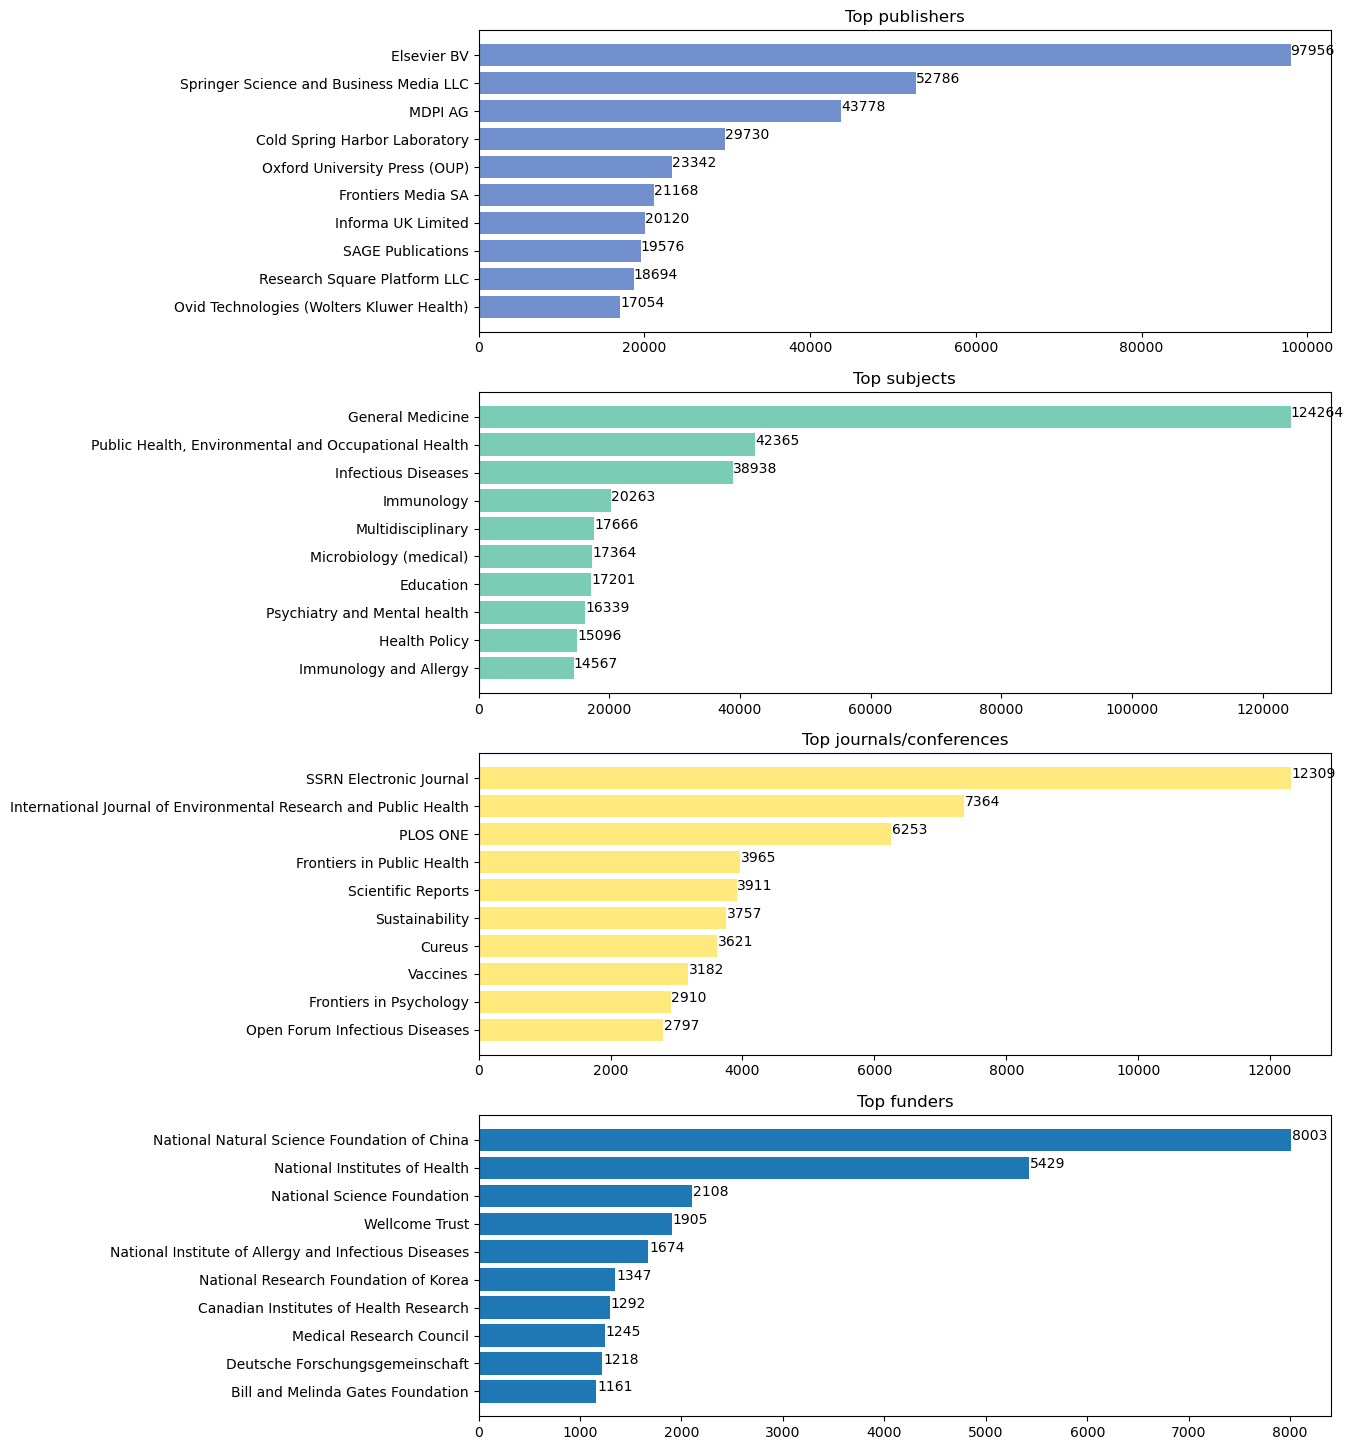

In [47]:
draw_subplots(top_n, count_publisher(df), count_subjects(df), count_container(df), count_funder(df))

### Metadata dependency matrix

In [29]:
top_n = 10

In [105]:
def draw_heatmap(df, metadata):
    fig = plt.figure(figsize=(8,6))
    x_axis_labels = [0, 1, 2, 3, 4, 5, 6, 7]

    conf_matrix_df = df.set_index(metadata)
    
    sns.heatmap(conf_matrix_df, annot=True, cmap="crest", xticklabels=x_axis_labels, fmt=".1f" )
    sns.set(font_scale=1.2)
    plt.xlabel('Clusters')
    plt.savefig('../img/Figure12-{}-by-cluster.png'.format(metadata), dpi=800, bbox_inches='tight') 
    plt.show()

#### Publisher

In [31]:
metadata = 'publisher'

# get top n publishers
publishers_df = count_publisher(df)
top_publishers = publishers_df.publisher[:top_n]
top_publishers = list(map(lambda x: re.sub("\(.*?\)|\[.*?\]","",x), top_publishers))

# create dependency matrix to save the percentage of articles with the publisher
publisher_df = pd.DataFrame()
publisher_df['publishers'] = top_publishers

for i in range(k):
    tmp_list = []
    tmp_df = df.loc[df['top1_cluster'] == str(i)]
    tmp_with_metadata_df = tmp_df.loc[tmp_df[metadata].notnull()]
    for w in top_publishers:
        num_of_articles_with_metadata = len(tmp_with_metadata_df.loc[tmp_with_metadata_df[metadata].str.contains(w)])
        tmp_list.append(round(num_of_articles_with_metadata/len(tmp_with_metadata_df)*100, 1))
    publisher_df['cluster#{}'.format(str(i))] = tmp_list
publisher_df.to_csv(PATH + "figure12_publisher-by-clusters.csv", index=False)

Missing publisher: 168 (0.0%)


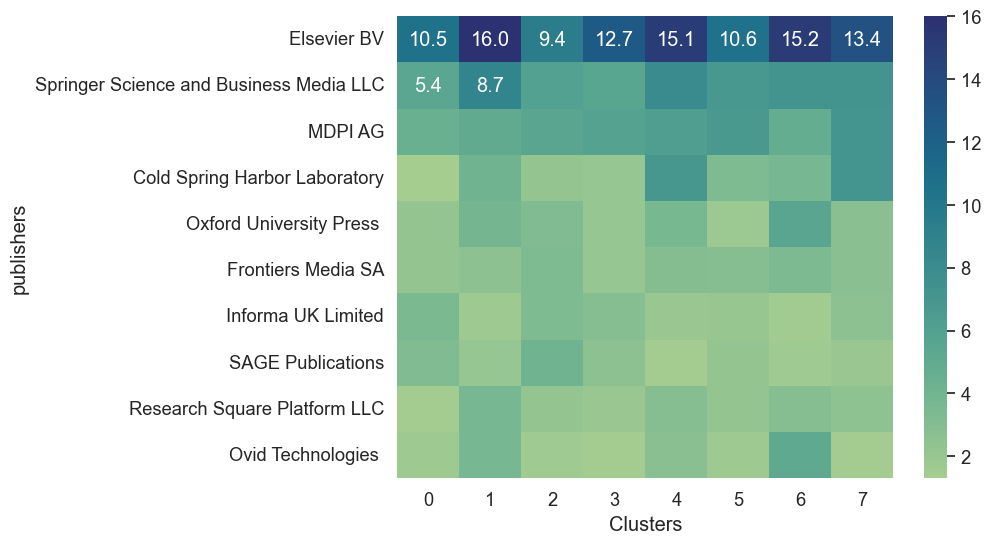

In [106]:
draw_heatmap(publisher_df, 'publishers')

#### Subject

In [94]:
metadata = 'Subject'
subject_df = count_subjects(df)
top_subjects = subject_df.Subjects[:top_n]
top_subjects = list(map(lambda x: re.sub("\(.*?\)|\[.*?\]","",x), top_subjects))

Missing subject: 266397 (34.5%)


In [95]:
# create dependency matrix to save the percentage of articles with the publisher
subject_df = pd.DataFrame()
subject_df[metadata] = top_subjects

for i in range(k):
    tmp_list = []
    tmp_df = df.loc[df['top1_cluster'] == str(i)]
    tmp_with_metadata_df = tmp_df.loc[tmp_df['subject'].notnull()]
    for w in top_subjects:
        num_of_articles_with_metadata = len(tmp_with_metadata_df.loc[tmp_with_metadata_df['subject'].str.contains(w)])
        tmp_list.append(round(num_of_articles_with_metadata/len(tmp_with_metadata_df)*100, 1))
    subject_df['cluster#{}'.format(str(i))] = tmp_list
subject_df.to_csv(PATH + "figure12_subjects-by-clusters.csv", index=False)

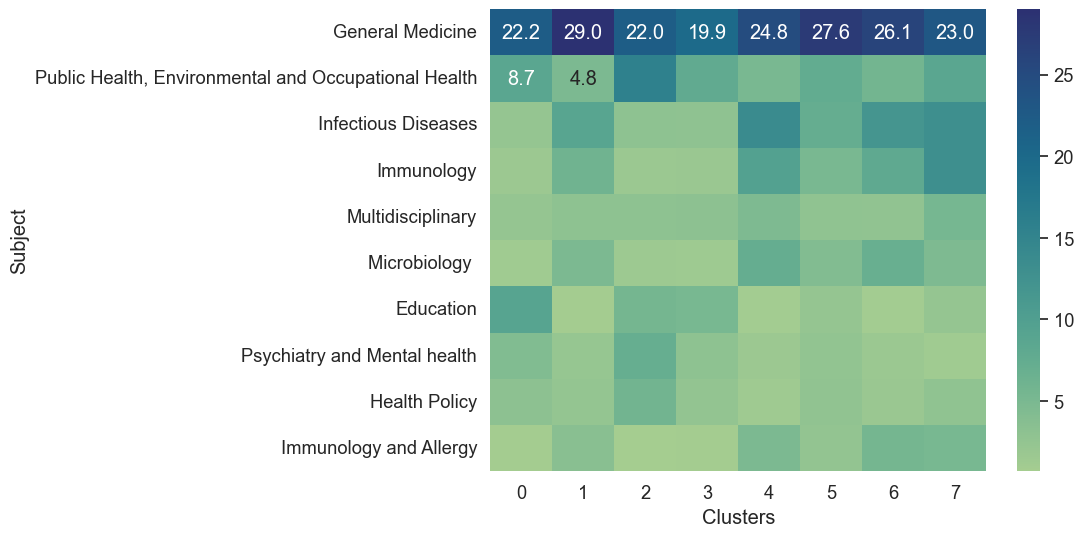

In [96]:
draw_heatmap(subject_df, 'Subject')

#### Journal

In [97]:
metadata = 'container-title'
journal_df = count_container(df)
top_journals = journal_df['container_title'][:top_n]
top_journals = list(map(lambda x: re.sub("\(.*?\)|\[.*?\]","",x), top_journals))

Missing container: 94058 (12.2%)


In [98]:
# create dependency matrix to save the percentage of articles with the journal
# code modified as string contain capture irrelevant journal

journal_df = pd.DataFrame()
journal_df[metadata] = top_journals

for i in range(k):
    tmp_list = []
    tmp_df = df.loc[df['top1_cluster'] == str(i)]
    tmp_with_metadata_df = tmp_df.loc[tmp_df[metadata] != 'nan']
    for w in top_journals:
        num_of_articles_with_metadata = len(tmp_with_metadata_df.loc[tmp_with_metadata_df[metadata] == "['{}']".format(w)])
        tmp_list.append(round(num_of_articles_with_metadata/len(tmp_with_metadata_df)*100, 1))
    journal_df['cluster#{}'.format(str(i))] = tmp_list
journal_df.to_csv(PATH + "figure12_journal-by-clusters.csv", index=False)

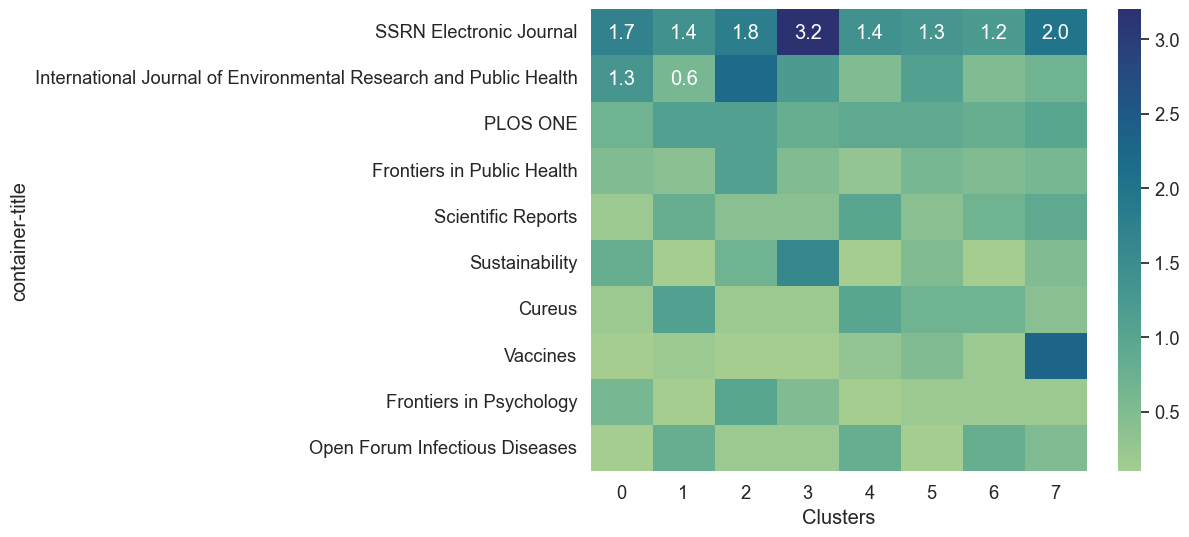

In [99]:
draw_heatmap(journal_df, 'container-title')

#### Funder

In [100]:
metadata = 'funder'
funder_df = count_funder(df)
top_funder = funder_df['Funders'][:top_n]
top_funder = list(map(lambda x: re.sub("\(.*?\)|\[.*?\]","",x), top_funder))

Missing funder: 666485 (86.2%)


In [101]:
# create dependency matrix to save the percentage of articles with the funder

funder_df = pd.DataFrame()
funder_df[metadata] = top_funder

for i in range(k):
    tmp_list = []
    tmp_df = df.loc[df['top1_cluster'] == str(i)]
    tmp_with_metadata_df = tmp_df.loc[tmp_df[metadata] != 'nan']
    for w in top_funder:
        num_of_articles_with_metadata = len(tmp_with_metadata_df.loc[tmp_with_metadata_df[metadata].str.contains(w)])
        tmp_list.append(round(num_of_articles_with_metadata/len(tmp_with_metadata_df)*100, 1))
    funder_df['cluster#{}'.format(str(i))] = tmp_list
funder_df.to_csv(PATH + "figure12_funder-by-clusters.csv", index=False)

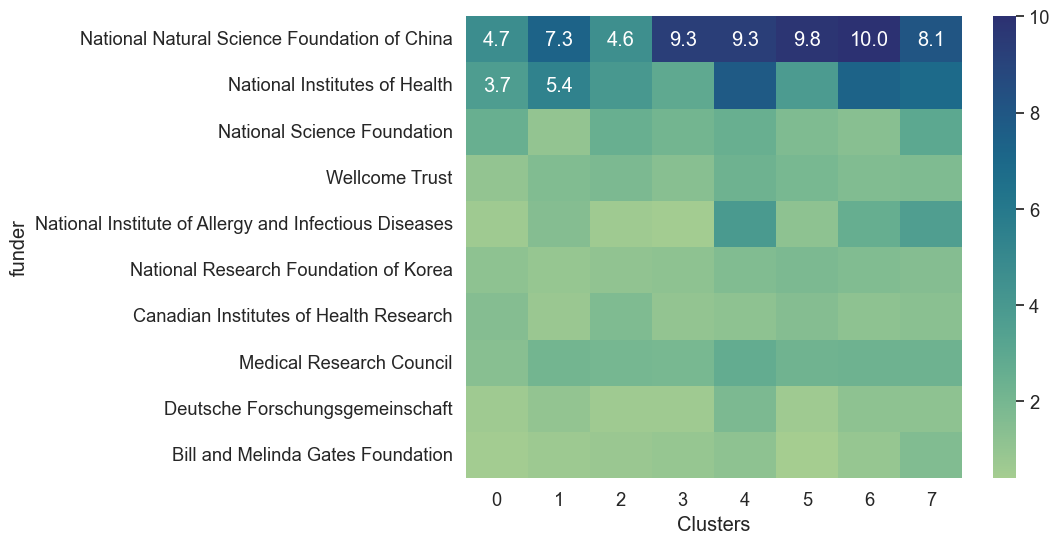

In [102]:
draw_heatmap(funder_df, 'funder')

In [112]:
# calculate the missing metadata by cluster
for c in range(k):
    cluster_df = df.loc[df['top1_cluster'] == str(c)]
    print("Cluster#{}: {}".format(c, len(cluster_df)))
    publishers_df = count_publisher(cluster_df)
    subject_df = count_subjects(cluster_df)
    journal_df = count_container(cluster_df)
    funder_df = count_funder(cluster_df)
    

Cluster#0: 140797
Missing publisher: 58 (0.0%)
Missing subject: 52464 (37.3%)
Missing container: 9328 (6.6%)
Missing funder: 126340 (89.7%)
Cluster#1: 105242
Missing publisher: 7 (0.0%)
Missing subject: 28940 (27.5%)
Missing container: 12023 (11.4%)
Missing funder: 90872 (86.3%)
Cluster#2: 125393
Missing publisher: 42 (0.0%)
Missing subject: 44493 (35.5%)
Missing container: 12623 (10.1%)
Missing funder: 109163 (87.1%)
Cluster#3: 83037
Missing publisher: 21 (0.0%)
Missing subject: 33389 (40.2%)
Missing container: 7884 (9.5%)
Missing funder: 73603 (88.6%)
Cluster#4: 105223
Missing publisher: 12 (0.0%)
Missing subject: 31887 (30.3%)
Missing container: 16625 (15.8%)
Missing funder: 86694 (82.4%)
Cluster#5: 47565
Missing publisher: 10 (0.0%)
Missing subject: 19125 (40.2%)
Missing container: 9602 (20.2%)
Missing funder: 41898 (88.1%)
Cluster#6: 45105
Missing publisher: 1 (0.0%)
Missing subject: 11736 (26.0%)
Missing container: 4471 (9.9%)
Missing funder: 38135 (84.5%)
Cluster#7: 120754
Missi

## Save the result

In [98]:
max_topic_num_list = []
topic_weights_list = []
for weights in H:
    top_idx = np.argsort(weights)[-1:]
    max_topic_num_list.append(top_idx[0])
    weight_dictionary = {}
    for i in range(len(weights)):
        weight_dictionary[i] = round(weights[i], 5)
    topic_weights_list.append(weight_dictionary) # save topic weights

# create new columns and save the results
df['research-topic'] = max_topic_num_list
df['topic-correlation'] = topic_weights_list

In [99]:
df.drop(columns=['top1_cluster'], inplace=True)

In [ ]:
df.to_csv(PATH + "NMF_topic_modelling_results({}clusters).csv".format(k), index=False)